# Homework 5

## Problem Description

You are given the data '04car_train.txt' which includes a set of cars with their attributes. Your goal is to build a linear model that considers the price of cars (the first column in the data) as the response of the other car attributes. The homework will be graded based on two parts: (80pt) The following report on model estimation and selection, and (20pt) the prediction performance of your model using a set of test data held by the TA. Details will be explained as follows.

## Preparation

* You will need numpy and matplotlib, as usual, but also the wonderful packages from [Scikit-Learn](http://scikit-learn.org/)

In [72]:
# use this if you are using ipython notebook, otherwise comment it out
%matplotlib inline 

# loading all packages... #
import numpy as np 
from sklearn import decomposition
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

import matplotlib.pyplot as plt

Note, we've given you several base packages here, but you may need to look at the documentation to find functions better suited to your needs. 

* Next, you will need to import the data, as an array. 
    - Make sure the .txt file is in the same directory/folder as your code. 

In [73]:
data = np.genfromtxt('dat_train.txt')
var=['price', 'engine size', 
      'cylinders', 'HP', 'City MPG', 
      'Highway MPG', 'Weight', 'Wheel base', 
      'Length', 'Width']

In class we talked about Data Standardization. Given that we will be using PCA and Linear Models, we don't want to pre-assign weights to the variable...that should be a discovered property. Therefore, we want the data columns to have a zeroed-out mean, and unit variance...i.e. their "position" and "scaling" should not be very different, while the trends in the data should be preserved. 

Find an appropriate scaling function in the `sklearn.preprocessing` sub-module, by reading the documentation [here](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing). Then, complete the import by erasing the `?` and replacing it with the proper function, after uncommenting the lines.

In [74]:
from sklearn.preprocessing import StandardScaler
scaler_func=StandardScaler()
y = data[:,0] #first columns
# covariates are the other columns. Dealer cost is not included since it correlates too much with the price #
X = data[:,1:] # all the others
scaler_func.fit(data)
#print scaler_func.transform(X,y=y).shape
data_scaled = scaler_func.transform(data) # preprocess the data
#target_scaled = (y - y.mean())/y.std()

## Step 0. Visualize your data (10pt)

#### Perform PCA on attributes and plot out all cars on the plan of PC1 and PC2. Tag cars with their prices. 
* Hint: PCA is a truncation of the matrices found in Singular Value Decomposition. You can use that fact to find the simplest function to use in the documentation [here](http://scikit-learn.org/stable/modules/decomposition.html#decompositions). Like before, find the appropriate function (this time in the `sklearn.decomposition` submodule) and complete the below code. 

* You may desire to see just how much variance is preserved in 2D space (how "good" you approximation is). you can use `svd.explained_variance_ratio_.sum()` to calculate the *sum* of explained variance in your projection as a fraction of the total (all PCs will be 100%, so 2 PCs should be something lower. Let's put this in the title of our plot. 

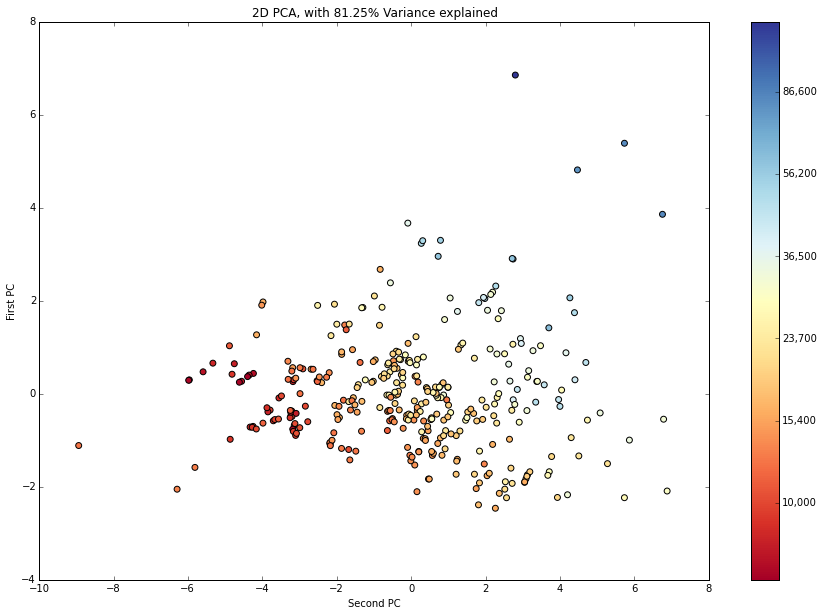

In [75]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=2)
X_pca = pca.fit_transform(data_scaled) # Projects data into 2-dimensions, using the two highest PCs

from matplotlib.colors import LogNorm # use a logscale for better visualization
fig, ax = plt.subplots(figsize=(15,10))
price = data[:,0] # the first column contains our (unscaled) prices
cm = plt.cm.get_cmap('RdYlBu') # what colormap type we want (red->yellow->blue)
sc = ax.scatter(X_pca[:,0], X_pca[:,1], 
                 norm=LogNorm(vmin=price.min(), vmax=price.max()), 
                 c=price, s=35, cmap=cm) # scatterplot, with color

cbar = fig.colorbar(sc, ticks=np.logspace(4., 5.5, num=9)) # add a bar for reference
cbar.ax.set_yticklabels(['{:,.0f}'.format(i) for i in np.round(np.logspace(4., 5.5, num=9),-2)])# what bar ticks to have

ax.set_title("2D PCA, with "+'{0:.2%}'.format(pca.explained_variance_ratio_.sum())+" Variance explained")
ax.set_ylabel("First PC")
ax.set_xlabel("Second PC")

Notice the trend/trends we see when we overlay prices? That indicates an underlying structure in the data...we never told it to order the data according to price, and yet they have a gradient of sorts. In other words, it seems as though price correlates well with the other variables quite ofter 


## Step 1. Create a simple linear model (20pt)

In [107]:
# response are car prices, i.e., the first column of the data matrix #
#y = scaler_func.fit_transform(np.log10(scaler_func.inverse_transform(data_scaled)[:,0]))
# covariates are the other columns. Dealer cost is not included since it correlates too much with the price #
X_train = data_scaled[:,1:]

# # split only on our side
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
# test_size=0.1, random_state=0)

# use the following for students
y_train = data_scaled[:,0]
# a set of linear models with polynomial terms
n, p = X_train.shape # get #samples and #dimensions

ncv = 15 # number of cross valiation 




lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)
error = ((lin_reg.predict(X_train) - y_train)**2).sum()

yhat = lin_reg.predict(X_train)


# Evaluate the models using crossvalidation
scores= cross_validation.cross_val_score(lin_reg,
    X_train, y_train, scoring="mean_squared_error", cv=ncv)

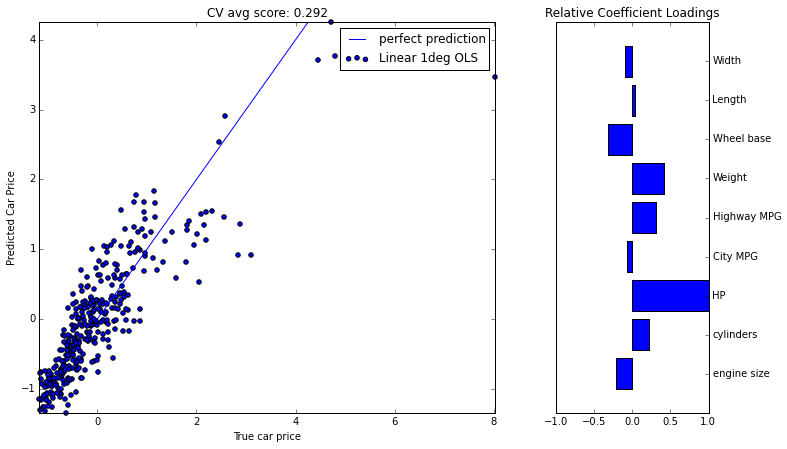

In [108]:
from matplotlib import gridspec
plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

ax = plt.subplot(gs[0])
plt.scatter(y_train, yhat, label="Linear 1deg OLS", clip_on=False)
plt.title("CV avg score: {:.3}".format(abs(scores.mean())))
plt.xlabel("True car price")
plt.ylabel("Predicted Car Price")
plt.xlim((min(y_train), max(y_train)))
plt.ylim((min(yhat), max(yhat)))
plt.plot(range(100000), label="perfect prediction")
plt.legend()

ax = plt.subplot(gs[1])
ypos = np.arange(len(var[1:]))
plt.barh(ypos, lin_reg.coef_/lin_reg.coef_.max(), align='center')
plt.yticks(ypos, var[1:])
ax.yaxis.tick_right()
plt.title("Relative Coefficient Loadings")
plt.xlim([-1,1])
fig.tight_layout(pad=1.9)

## Step 2. Now use the same code to create multiple models and compare (30pt)

Compare models using crossvalidation, AIC and BIC. Discuss how model complex affects the training error and these model selection criteria.

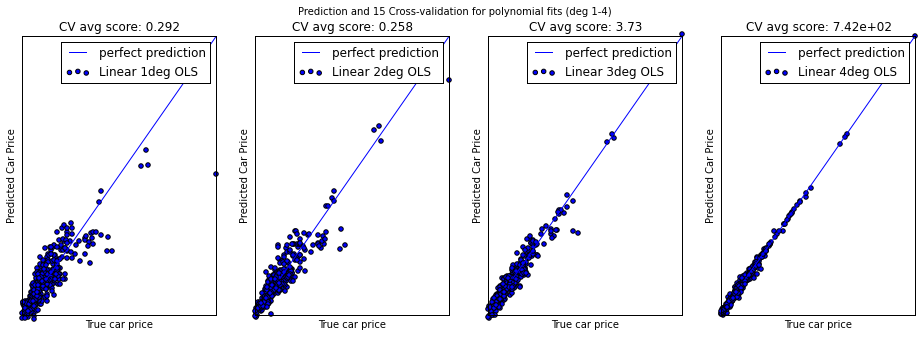

In [109]:

# loading all packages... #
import numpy as np 
from sklearn import decomposition
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# response are car prices, i.e., the first column of the data matrix #
#y = data_scaled[:,0]
#y = scaler_func.fit_transform(np.log10(scaler_func.inverse_transform(data_scaled)[:,0]))

# covariates are the other columns. Dealer cost is not included since it correlates too much with the price #
# X = data_scaled[:,2:data_scaled.shape[1]]

# # split only on our side
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
# test_size=0.1, random_state=0)

# use the following for students
#X_train = data_scaled[:]
#y_train = y

# a set of linear models with polynomial terms
n, p = X_train.shape # get #samples and #dimensions
degrees = [1, 2, 3, 4] 
error = np.zeros(len(degrees)) # training error
scores = np.zeros((len(degrees),ncv)) # cv error

fig=plt.figure(figsize=(16, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1, sharey=ax)
    plt.setp(ax, xticks=(), yticks=())
    
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=True,
                                             interaction_only=True)
    linear_regression = LinearRegression(fit_intercept=True)

    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train, y_train)
    error[i] = ((pipeline.predict(X_train) - y_train)**2).sum()
    
    yhat = pipeline.predict(X_train)

    # Evaluate the models using crossvalidation
    scores[i,] = cross_validation.cross_val_score(pipeline,
        X_train, y_train, scoring="mean_squared_error", cv=ncv)
    #print scores[i,]
    #print pipeline.
    plt.scatter(y_train, yhat, label="Linear "+str(i+1)+"deg OLS", clip_on=False)
    plt.title("CV avg score: {:.3}".format(abs(scores[i,].mean())))

    plt.xlim((min(y_train), max(y_train)))
    plt.ylim((min(yhat), max(yhat)))
    plt.plot(range(100000), label="perfect prediction")
    
    plt.xlabel("True car price")
    plt.ylabel("Predicted Car Price")

    plt.legend()
fig.suptitle("Prediction and "+str(ncv)+" Cross-validation for polynomial fits (deg 1-4)")

# Step 3. Propose your own model and compare with the above ones (20pt)

Propose your own linear model (does not have to contain only polynomial terms). Report its crossvalidation, AIC and BIC scores. 

* HINT: We suggest taking a look at some of the trends you found in the PCA. Sometimes polynomial transformations of your data is not the best...
* ANYTHING in the form $$y = a_1 f_1({\bf x}) +a_2 f_2({\bf x}) + \cdots + a_n f_n({\bf x})$$ will work fine, but you will need $n$ columns in your matrix that you fit, with each column being the $f_i({\bf})$ transform. Think about how some of the variables should actually correlate (linear relationships rarely are a physical reality). 
* If you're struggling to find a good model, try plotting histograms (remember HW1?) of the individual variables. If there are ranges with unusually large counts, you may or may not want to find a function that weights that variable accordingly. 

## Example: LASSO 
Below is another linear regression method. You are not required to know how this works, but we wanted to show you what a slightly more sophisticated regression might look like. Here, we penalize having too many variables by adjusting a prameter alpha (alpha 0 will return OLS exactly). The "best" alpha is found via cross-validation. Generally, when we can remove variables that are deemed useless, the prediction will behave better for previously unseen data. 

In [110]:
from sklearn.linear_model import LassoCV, Lasso

model=LassoCV(cv=ncv, fit_intercept=False) #alpha based on CV for ncv from above

model.fit(X_train, y_train)
yhat = model.predict(X_train)
print model.alpha_

scores = cross_validation.cross_val_score(model,
        X_train, y_train, scoring="mean_squared_error", cv=ncv)
print "CV avg MSE ",-1*scores.mean()
print model.coef_

0.004770752071
CV avg MSE  0.292825190758
[-0.11845067  0.14636146  0.87190816 -0.          0.18555565  0.2716919
 -0.22830762  0.         -0.06182709]


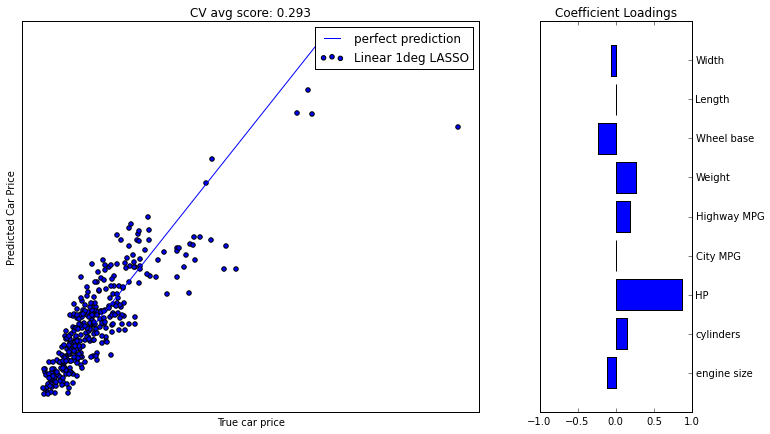

In [111]:
from matplotlib import gridspec
plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

ax = plt.subplot(gs[0])

plt.setp(ax, xticks=(), yticks=())
plt.scatter(y_train, yhat, label="Linear 1deg LASSO", clip_on=False)


plt.title("CV avg score: {:.3}".format(abs(scores.mean())))
plt.xlabel("True car price")
plt.ylabel("Predicted Car Price")
plt.plot(range(6), label="perfect prediction")
#plt.xlim((min(y), max(y)))
#plt.ylim((min(yhat), max(yhat)))
plt.legend()


ax = plt.subplot(gs[1])
ypos = np.arange(len(var[1:]))
plt.barh(ypos, model.coef_, align='center')
plt.yticks(ypos, var[1:])
ax.yaxis.tick_right()
plt.title("Coefficient Loadings")
plt.xlim([-1,1])
fig.tight_layout(pad=1.9)

2.3214131525


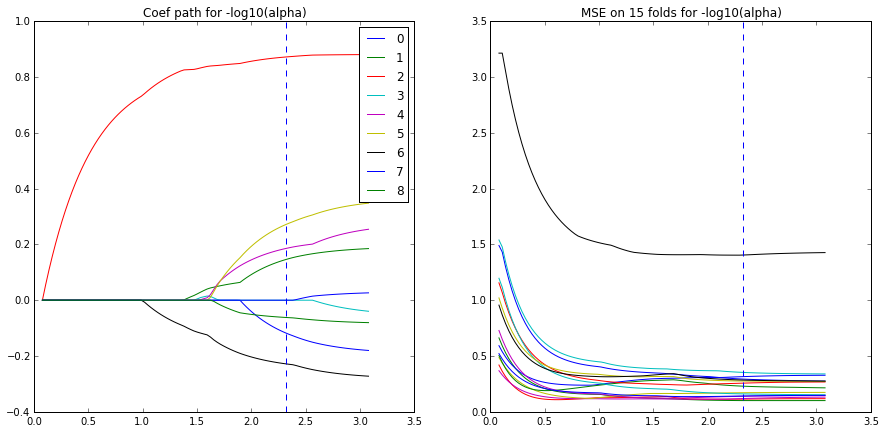

In [112]:
#print model.path(X,y)[1]
fig, ax=plt.subplots(ncols=2, figsize=(15,7))
print -np.log10(model.alpha_)
ax[0].plot(-np.log10(model.path(X_train, y_train)[0]), model.path(X_train,y_train)[1].T)
ax[0].legend([str(i) for i in range(9)], loc=0)
ax[0].axvline(x=-np.log10(model.alpha_), ls='--')
ax[0].set_title("Coef path for -log10(alpha)")
#ax[0].set_ylim((-5,5))
ax[1].plot(-np.log10(model.alphas_), model.mse_path_)
ax[1].axvline(x=-np.log10(model.alpha_), ls='--')
ax[1].set_title("MSE on "+str(ncv)+" folds for -log10(alpha)")

## Example Validation: 
This is where things get interesting: I'll import the test set that we've been saving this whole time. Unlike cross-validation, now our model has *never* seen this data, and won't be able to learn from it...we simply are testing it's prediction ability. 

Note that LASSO performs just slightly better. How does yours do? 

(39L, 10L)


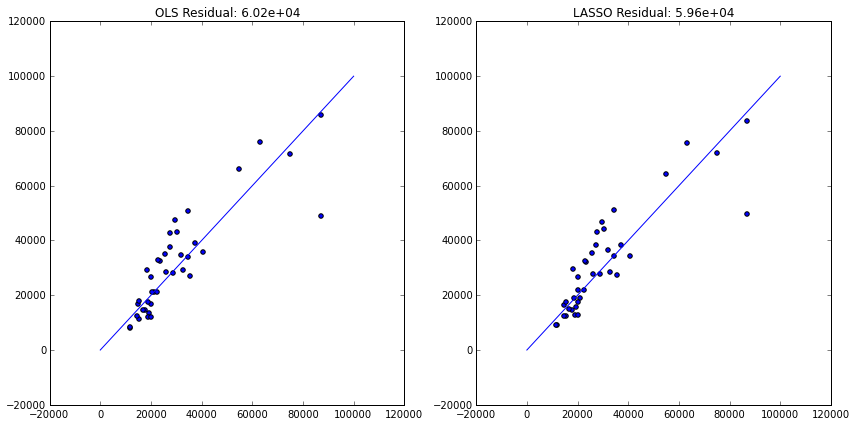

In [113]:
#import the test data
test = np.genfromtxt("dat_test.txt") 
print test.shape
test_scaled = scaler_func.transform(test)
Xt = test_scaled[:,1:]
#print test[:,1:].mean(axis=0)
yt_scale = test_scaled[:,0]
yt = test[:,0]

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
# First the Linear OLS
yhat_scale=lin_reg.predict(Xt)
yhat = yhat_scale*y.std()+y.mean()

ax[0].scatter(yt, yhat)
ax[0].plot(range(100000))
residual = np.sqrt(np.sum((yt-yhat)**2))
ax[0].set_title("OLS Residual: {:.3}".format(residual))

#Now the LASSO
yhat_scale=model.predict(Xt)
yhat = yhat_scale*y.std()+y.mean()


ax[1].scatter(yt, yhat)
ax[1].plot(range(100000))
residual = np.sqrt(np.sum((yt-yhat)**2))
ax[1].set_title("LASSO Residual: {:.3}".format(residual))

fig.tight_layout()